In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, make_scorer, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay)
import shap
import warnings
warnings.filterwarnings("ignore")

In [32]:
finalfile=pd.read_csv("finalfile.txt", sep="\t")

In [33]:
finalfile.dtypes

strain             object
A1C                 int64
A1G                 int64
A1T                 int64
T2G                 int64
                    ...  
Nextclade_pango    object
region             object
country            object
category           object
Collection date    object
Length: 16424, dtype: object

In [34]:
finalfile["Collection date"] = pd.to_datetime(
    finalfile["Collection date"], 
    format="mixed", 
    dayfirst=True)

In [35]:
print(finalfile["Collection date"].dtypes)
print(finalfile["Collection date"].head())

datetime64[ns]
0   2024-01-12
1   2024-01-03
2   2024-01-06
3   2024-01-30
4   2024-01-01
Name: Collection date, dtype: datetime64[ns]


In [36]:
final_df=finalfile

In [37]:
final_df

strain  A1C  A1G  A1T  T2G  T2K  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024    0    0    0    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024    0    0    0    1    0   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024    0    0    0    1    0   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024    0    0    0    1    0   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024    0    0    0    1    0   
...                                            ...  ...  ...  ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024    0    0    0    1    0   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024    0    0    0    1    0   
13970                 hCoV-19/USA/NY-WMC-6178/2024    0    0    0    1    0   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024    0    0    0    1    0   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024    0    0    0    1    0   

       T2A  T2C  T3C  T3A  ...  A29891G  A29892G  Gender  Patient age  \
0        0    0    0    0  ...        0        0    Male        87.00   
1        0    0    1    0  ...        1        1  Female        91.00   
2        0    0    1    0  ...        1        1    Male        35.00   
3        0    0    1    0  ...        1        1    Male        70.00   
4        0    0    1    0  ...        1        1  Female        19.00   
...    ...  ...  ...  ...  ...      ...      ...     ...          ...   
13968    0    0    1    0  ...        1        1    Male        94.00   
13969    0    0    1    0  ...        1        1  Female        81.00   
13970    0    0    1    0  ...        1        1    Male         0.42   
13971    0    0    1    0  ...        1        1  Female        26.00   
13972    0    0    1    0  ...        1        1    Male        38.00   

             clade  Nextclade_pango         region   country  category  \
0              19A                B         Europe    Turkey    Severe   
1      recombinant              XCU         Europe  Slovakia    Severe   
2              21K             BA.1  South America    Brazil    Severe   
3              23F         EG.5.1.1           Asia     China    Severe   
4              23H             HK.3           Asia     China    Severe   
...            ...              ...            ...       ...       ...   
13968          24A         JN.1.4.9         Europe     Spain    Severe   
13969          24E         KP.3.1.1         Europe     Spain    Severe   
13970          24A           JN.1.4  North America       USA    Severe   
13971          23B      XBB.1.16.15  North America    Mexico    Severe   
13972          23G             GK.1  South America    Brazil    Severe   

       Collection date  
0           2024-01-12  
1           2024-01-03  
2           2024-01-06  
3           2024-01-30  
4           2024-01-01  
...                ...  
13968       2024-05-03  
13969       2024-10-11  
13970       2024-03-01  
13971       2024-02-08  
13972       2024-02-04  

[13973 rows x 16424 columns]

In [38]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64


In [39]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int64


In [40]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)

In [41]:
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [42]:
final_df

strain  A1C  A1G  A1T  T2G  T2K  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024    0    0    0    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024    0    0    0    1    0   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024    0    0    0    1    0   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024    0    0    0    1    0   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024    0    0    0    1    0   
...                                            ...  ...  ...  ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024    0    0    0    1    0   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024    0    0    0    1    0   
13970                 hCoV-19/USA/NY-WMC-6178/2024    0    0    0    1    0   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024    0    0    0    1    0   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024    0    0    0    1    0   

       T2A  T2C  T3C  T3A  ...  Nextclade_pango_XEL.3  Nextclade_pango_XEP  \
0        0    0    0    0  ...                      0                    0   
1        0    0    1    0  ...                      0                    0   
2        0    0    1    0  ...                      0                    0   
3        0    0    1    0  ...                      0                    0   
4        0    0    1    0  ...                      0                    0   
...    ...  ...  ...  ...  ...                    ...                  ...   
13968    0    0    1    0  ...                      0                    0   
13969    0    0    1    0  ...                      0                    0   
13970    0    0    1    0  ...                      0                    0   
13971    0    0    1    0  ...                      0                    0   
13972    0    0    1    0  ...                      0                    0   

       Nextclade_pango_XEU  Nextclade_pango_XEV  Nextclade_pango_XEW  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
13968                    0                    0                    0   
13969                    0                    0                    0   
13970                    0                    0                    0   
13971                    0                    0                    0   
13972                    0                    0                    0   

       Nextclade_pango_XFB  Nextclade_pango_XFC  Nextclade_pango_XFG  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
13968                    0                    0                    0   
13969                    0                    0                    0   
13970                    0                    0                    0   
13971                    0                    0                    0   
13972                    0                    0                    0   

       Nextclade_pango_XFJ  Nextclade_pango_XFL  
0                        0                    0  
1                        0                    0  
2                        0                    0  
3                        0                    0  
4                        0                    0  
...                    ...                  ...  
13968                    0                    0  
13969                    0  

In [43]:
first_col = final_df.loc[:, ["strain", "Collection date"]]

In [44]:
rest = final_df.drop(columns=["strain", "Collection date","country","region"])
rest

A1C  A1G  A1T  T2G  T2K  T2A  T2C  T3C  T3A  A4T  ...  \
0        0    0    0    0    0    0    0    0    0    0  ...   
1        0    0    0    1    0    0    0    1    0    1  ...   
2        0    0    0    1    0    0    0    1    0    1  ...   
3        0    0    0    1    0    0    0    1    0    1  ...   
4        0    0    0    1    0    0    0    1    0    1  ...   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
13968    0    0    0    1    0    0    0    1    0    1  ...   
13969    0    0    0    1    0    0    0    1    0    1  ...   
13970    0    0    0    1    0    0    0    1    0    1  ...   
13971    0    0    0    1    0    0    0    1    0    1  ...   
13972    0    0    0    1    0    0    0    1    0    1  ...   

       Nextclade_pango_XEL.3  Nextclade_pango_XEP  Nextclade_pango_XEU  \
0                          0                    0                    0   
1                          0                    0                    0   
2                          0                    0                    0   
3                          0                    0                    0   
4                          0                    0                    0   
...                      ...                  ...                  ...   
13968                      0                    0                    0   
13969                      0                    0                    0   
13970                      0                    0                    0   
13971                      0                    0                    0   
13972                      0                    0                    0   

       Nextclade_pango_XEV  Nextclade_pango_XEW  Nextclade_pango_XFB  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
13968                    0                    0                    0   
13969                    0                    0                    0   
13970                    0                    0                    0   
13971                    0                    0                    0   
13972                    0                    0                    0   

       Nextclade_pango_XFC  Nextclade_pango_XFG  Nextclade_pango_XFJ  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
13968                    0                    0                    0   
13969                    0                    0                    0   
13970                    0                    0                    0   
13971                    0                    0                    0   
13972                    0                    0                    0   

       Nextclade_pango_XFL  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
13968                    0  
13969                    0  
13970                    0  
13971                    0  
13972                    0  

[13973 rows x 17067 columns]

In [45]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13973, 9606)


In [46]:
final_df_filtered

strain Collection date  T2G  T3C  \
0       hCoV-19/Turkey/TSIM_Ankara_140111_978/2024      2024-01-12    0    0   
1      hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024      2024-01-03    1    1   
2                hCoV-19/Brazil/RJ-FIOCRUZ-51/2024      2024-01-06    1    1   
3               hCoV-19/Fujian/FCDC-FZ9970725/2024      2024-01-30    1    1   
4              hCoV-19/Fujian/FCDC-XM010309HG/2024      2024-01-01    1    1   
...                                            ...             ...  ...  ...   
13968     hCoV-19/Spain/CT-LabRefCat-9317885r/2024      2024-05-03    1    1   
13969     hCoV-19/Spain/CT-LabRefCat-6385185r/2024      2024-10-11    1    1   
13970                 hCoV-19/USA/NY-WMC-6178/2024      2024-03-01    1    1   
13971        hCoV-19/Mexico/GUA_CIAD_01001002/2024      2024-02-08    1    1   
13972          hCoV-19/Brazil/SC-FIOCRUZ-1104/2024      2024-02-04    1    1   

       A4T  A4C  A5G  A6R  G7T  G8T  ...  Nextclade_pango_XEC.15  \
0        0    0    0    0    0    0  ...                       0   
1        1    0    1    1    1    1  ...                       0   
2        1    0    1    1    1    1  ...                       0   
3        1    0    1    1    1    1  ...                       0   
4        1    0    1    1    1    1  ...                       0   
...    ...  ...  ...  ...  ...  ...  ...                     ...   
13968    1    0    1    1    1    1  ...                       0   
13969    1    0    1    1    1    1  ...                       0   
13970    1    0    1    1    1    1  ...                       0   
13971    1    0    1    1    1    1  ...                       0   
13972    1    0    1    1    1    1  ...                       0   

       Nextclade_pango_XEC.18  Nextclade_pango_XEC.2  Nextclade_pango_XEC.30  \
0                           0                      0                       0   
1                           0                      0                       0   
2                           0                      0                       0   
3                           0                      0                       0   
4                           0                      0                       0   
...                       ...                    ...                     ...   
13968                       0                      0                       0   
13969                       0                      0                       0   
13970                       0                      0                       0   
13971                       0                      0                       0   
13972                       0                      0                       0   

       Nextclade_pango_XEC.32  Nextclade_pango_XEC.4  Nextclade_pango_XEC.8  \
0                           0                      0                      0   
1                           0                      0                      0   
2                           0                      0                      0   
3                           0                      0                      0   
4                           0                      0                      0   
...                       ...                    ...                    ...   
13968                       0                      0                      0   
13969                       0                      0                      0   
13970                       0                      0                      0   
13971                       0                      0                      0   
13972                       0                      0                      0   

       Nextclade_pango_XEC.9  Nextclade_pango_XEE  Nextclade_pango_XEK  
0                          0                    0                    0  
1                          0                    0                    0  
2                          0                    0                    0  
3                          0                    0               

In [47]:
X = final_df_filtered.drop(columns=['category', 'strain', 'Collection date'])

In [48]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

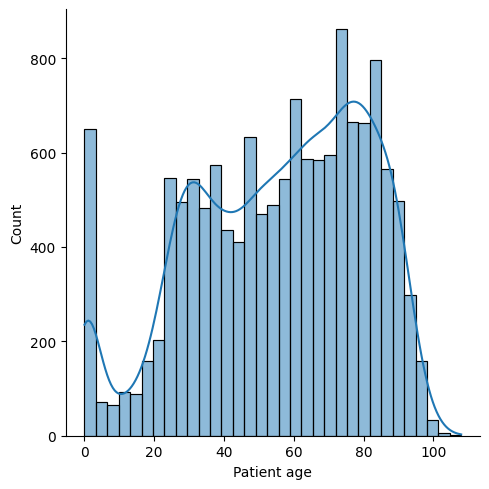

In [49]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [50]:
p = final_df_filtered["Collection date"].dt.to_period("M")
time_points = p.sort_values().unique()

In [51]:
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        m = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.any(m):
            acc = np.mean(y_true[m])
            conf = np.mean(y_prob[m])
            ece += (np.sum(m) / len(y_true)) * np.abs(acc - conf)
    return float(ece)

def choose_bins(n_train: int, n_test: int, min_per_bin: int = 50,
                min_bins: int = 5, max_bins: int = 20) -> int:
    n = min(int(n_train), int(n_test))
    return max(min_bins, min(max_bins, n // min_per_bin))

In [52]:
def compute_psi_quantile(expected, actual, bins: int = None, eps: float = 1e-6):
    expected = np.asarray(expected, dtype=float)
    actual   = np.asarray(actual, dtype=float)
    if bins is None:
        bins = choose_bins(len(expected), len(actual))
    if np.nanstd(expected) == 0 and np.nanstd(actual) == 0:
        return 0.0
    q = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(expected, q))
    if len(edges) < 3:
        return 0.0
    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual,   bins=edges)
    exp_prop = exp_counts / max(1, exp_counts.sum())
    act_prop = act_counts / max(1, act_counts.sum())
    exp_prop = np.where(exp_prop == 0, eps, exp_prop)
    act_prop = np.where(act_prop == 0, eps, act_prop)
    return float(np.sum((exp_prop - act_prop) * np.log(exp_prop / act_prop)))

In [53]:
def shap_values_2d(model, X_train):
    explainer = shap.TreeExplainer(model)
    sv = explainer.shap_values(X_train)
    if isinstance(sv, list) and len(sv) == 2:
        sv = sv[1]
    return np.asarray(sv)


In [54]:
n_months = final_df_filtered["Collection date"].dt.to_period("M").nunique()
print("Number of unique months:", n_months)

Number of unique months: 17


In [55]:
def recalibrate_predictions(y_train_true, p_train, p_test,
                            method="logistic", use_logits=False, C=0.1, return_diag=False):
   
    if method != "logistic":
        raise ValueError("Only method='logistic' is implemented.")

    eps = 1e-6
    p_train = np.asarray(p_train, dtype=float)
    p_test  = np.asarray(p_test,  dtype=float)

    if use_logits:
        z_train = p_train.reshape(-1, 1)
        z_test  = p_test.reshape(-1, 1)
    else:
        p_train = np.clip(p_train, eps, 1 - eps)
        p_test  = np.clip(p_test,  eps, 1 - eps)
        z_train = np.log(p_train / (1.0 - p_train)).reshape(-1, 1)
        z_test  = np.log(p_test  / (1.0 - p_test)).reshape(-1, 1)

    lr = LogisticRegression(solver="lbfgs", max_iter=1000, penalty="l2", C=C)
    lr.fit(z_train, y_train_true.astype(int))
    p_test_cal = lr.predict_proba(z_test)[:, 1]

    p_train_cal = lr.predict_proba(z_train)[:, 1]

    diag = {
        'brier_cal': brier_score_loss(y_train_true, p_train_cal),
        'psi_cal_vs_orig': compute_psi_quantile(p_train, p_train_cal)
    }

    if return_diag:
        return p_test_cal, lr, diag
    else:
        return p_test_cal, lr, diag


In [56]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_auc_score, brier_score_loss
from lightgbm import LGBMClassifier

results = []

p = final_df_filtered["Collection date"].dt.to_period("M")
time_points = pd.period_range(p.min(), p.max(), freq="M")
start_after = 3

for i in range(start_after, len(time_points)-1):
    train_end = time_points[i]
    test_end  = time_points[i+1]

    train_idx = p <= train_end
    test_idx  = (p > train_end) & (p <= test_end)

    if test_idx.sum() < 20 or train_idx.sum() < 80:
        continue

    print(f"Split {i}: train_end={train_end}, test_end={test_end}, n_train={train_idx.sum()}, n_test={test_idx.sum()}")

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    scaler = StandardScaler()
    X_train[["Patient age"]] = scaler.fit_transform(X_train[["Patient age"]])
    X_test[["Patient age"]] = scaler.transform(X_test[["Patient age"]])

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    param_dist = {
        'n_estimators': randint(500, 2100),
        'max_depth': randint(10, 41),
        'learning_rate': uniform(0.001, 0.099),
        'num_leaves': randint(10, 51)
    }
    cv = KFold(n_splits=5, shuffle=False)
    scorer = make_scorer(accuracy_score)
    model = LGBMClassifier()
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scorer,
        cv=cv,
        verbose=2,
        n_jobs=2,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_prob_train = best_model.predict_proba(X_train)[:, 1]
    y_prob_train_full = y_prob_train
    psi_score_raw = compute_psi_quantile(y_prob_train, y_prob)

    print("\nBest Parameters Found:", random_search.best_params_)
    print("\nTest Set Performance:")
    print(confusion_matrix(y_test, y_pred))
    print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

    auc = roc_auc_score(y_test, y_prob)
    ece = compute_ece(y_test, y_prob, n_bins=10)
    brier = brier_score_loss(y_test, y_prob)
    auc_full, brier_full, ece_full = auc, brier, ece

    sv = shap_values_2d(best_model, X_train)
    mean_abs_shap = np.mean(np.abs(sv), axis=0)
    top_idx = np.argsort(mean_abs_shap)[-10:]
    top_feats = [X_train.columns[j] for j in top_idx]

    psi_feat = {f: compute_psi_quantile(X_train[f], X_test[f]) for f in top_feats}
    avg_psi_top10 = float(np.mean(list(psi_feat.values())))
    max_psi_top10 = float(np.max(list(psi_feat.values())))

    auroc_thresh = 0.70
    psi_feat_thresh = 0.25
    pred_psi_thresh = 1.5

    if (auc_full < auroc_thresh) or (max_psi_top10 >= psi_feat_thresh) or (avg_psi_top10 >= psi_feat_thresh):
        status = "Retraining needed"
    elif (0.10 <= avg_psi_top10 < psi_feat_thresh) or psi_score_raw > pred_psi_thresh:
        status = "Recalibration needed.Max_PSI exceeded"
    else:
        status = "Stable"

    initial_status = status
    model_used = "full"
    retrain_note = ""
    y_prob_used = y_prob
    auc_used, brier_used, ece_used = auc_full, brier_full, ece_full

    y_cal_train = y_train
    y_cal_train_probs = y_prob_train_full

    if status == "Retraining needed":
        lookback_months = 3
        recent_start_ts = train_end.to_timestamp() - pd.DateOffset(months=lookback_months)
        recent_mask = (final_df_filtered["Collection date"] > recent_start_ts) & \
                      (final_df_filtered["Collection date"] <= train_end.to_timestamp())
        recent_mask = recent_mask.loc[X.index]
        recent_mask &= train_idx.loc[X.index]
        n_recent = int(recent_mask.sum())

        if n_recent >= 200:
            X_trn_recent = X.loc[recent_mask].drop(columns=["Collection date"], errors="ignore").copy()
            if ("Patient age" in X_trn_recent.columns) and (scaler is not None):
                X_trn_recent[["Patient age"]] = scaler.transform(X_trn_recent[["Patient age"]])
            y_trn_recent = y.loc[recent_mask].astype(np.float32)
            X_trn_recent = clean_features(X_trn_recent)

            random_search_ret = RandomizedSearchCV(
                estimator=LGBMClassifier(),
                param_distributions=param_dist,
                n_iter=50,
                scoring=scorer,
                cv=cv,
                verbose=2,
                n_jobs=2,
                random_state=42
            )
            random_search_ret.fit(X_trn_recent, y_trn_recent)
            retrained_model = random_search_ret.best_estimator_

            y_prob_train_recent = retrained_model.predict_proba(X_trn_recent)[:, 1]
            y_prob2 = retrained_model.predict_proba(X_test)[:, 1]

            auc2 = roc_auc_score(y_test, y_prob2)
            brier2 = brier_score_loss(y_test, y_prob2)
            ece2 = compute_ece(y_test, y_prob2, n_bins=10)

            choose_retrained = (auc2 > auc_used) or (np.isclose(auc2, auc_used) and brier2 <= brier_used)
            if choose_retrained:
                model_used = "retrained_recent"
                retrain_note = f"Retrained on last {lookback_months} months (n={n_recent}). Model stable after recalibration."
                y_prob_used = y_prob2
                auc_used, brier_used, ece_used = auc2, brier2, ece2
                y_cal_train = y_trn_recent
                y_cal_train_probs = y_prob_train_recent
            else:
                retrain_note = f"Retraining tried (n={n_recent}) but original full model retained."
        else:
            retrain_note = f"Retrain skipped (recent window too small: n={n_recent})."

    y_prob_test_cal, cal_model, diag = recalibrate_predictions(
        y_cal_train, y_cal_train_probs, y_prob_used, method="logistic", C=0.1
    )

    auc_before = roc_auc_score(y_test, y_prob_used)
    brier_before = brier_score_loss(y_test, y_prob_used)
    psi_before = compute_psi_quantile(y_cal_train_probs, y_prob_used)

    auc_after = roc_auc_score(y_test, y_prob_test_cal)
    brier_after = brier_score_loss(y_test, y_prob_test_cal)
    psi_after = compute_psi_quantile(y_cal_train_probs, y_prob_test_cal)

    print(f"AUROC before: {auc_before:.3f} after: {auc_after:.3f}")
    print(f"Brier before: {brier_before:.3f} after: {brier_after:.3f}")
    print(f"PSI (raw scores) before: {psi_before:.3f} after: {psi_after:.3f}")
    print("Calib Brier (train):", diag.get('brier_cal'), " Calib-PSI:", diag.get('psi_cal_vs_orig'))

    if initial_status.startswith("Recalibration"):
        if (auc_after >= auc_before) or (brier_after <= brier_before) or (psi_after <= psi_before):
            status = "Stable after recalibration"
        else:
            status = "Not stable after recalibration"
    else:
        status = initial_status

    print(f"\n[{str(train_end)} ➜ {str(test_end)}] AUROC={auc_used:.3f} | ECE={ece_used:.3f} | Brier={brier_used:.3f} | "
          f"AvgPSI_top10={avg_psi_top10:.3f} | MaxPSI_top10={max_psi_top10:.3f} | ScorePSI_raw={psi_score_raw:.3f} | "
          f"Status={status} | ModelUsed={model_used} | {retrain_note}")

    top3 = sorted(psi_feat.items(), key=lambda kv: kv[1], reverse=True)[:3]
    results.append({
        "train_end": str(train_end),
        "test_end": str(test_end),
        "n_train": int(train_idx.sum()),
        "n_test": int(test_idx.sum()),
        "AUROC": float(auc_used),
        "ECE": float(ece_used),
        "Brier": float(brier_used),
        "Avg_PSI_top10": avg_psi_top10,
        "Max_PSI_top10": max_psi_top10,
        "Score_PSI_raw": float(psi_score_raw),
        "InitialStatus": initial_status,
        "FinalStatus": status,
        "ModelUsed": model_used,
        "RetrainNote": retrain_note,
        "Top10_features": ",".join(top_feats),
        "Top3_PSI_features": ",".join([f"{k}:{psi_feat[k]:.3f}" for k, _ in top3]),
        "AUROC_after_cal": float(auc_after),
        "Brier_after_cal": float(brier_after),
        "Score_PSI_after_cal": float(psi_after),
    })

results_df = pd.DataFrame(results)
print(results_df.head())


Split 3: train_end=2024-04, test_end=2024-05, n_train=4973, n_test=1110
(4973, 9603) (1110, 9603) (4973,) (1110,)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3393, number of negative: 1580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7646
[LightGBM] [Info] Number of data points in the train set: 4973, number of used features: 3766
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.682284 -> initscore=0.764290
[LightGBM] [Info] Start training from score 0.764290

Best Parameters Found: {'learning_rate': np.float64(0.0015466895952366377), 'max_depth': 20, 'n_estimators': 2022, 'num_leaves': 26}

Test Set Performance:
[[237  57]
 [280 536]]
Test ROC 

In [57]:
results_df.to_csv("resultslightgbmwithcountryregiontemporal.txt", sep="\t", index=False)

In [58]:
top10_split = results_df["Top10_features"].str.split(",", expand=True)
top10_split.columns = [f"TopFeat_{i+1}" for i in range(10)]
results_expandedlightgbm = pd.concat([results_df, top10_split], axis=1)

print(results_expandedlightgbm.head())


  train_end test_end  n_train  n_test     AUROC       ECE     Brier  \
0   2024-04  2024-05     4973    1110  0.778555  0.121763  0.177951   
1   2024-05  2024-06     6083    1595  0.871227  0.088862  0.150290   
2   2024-06  2024-07     7678    2130  0.774690  0.060750  0.193008   
3   2024-07  2024-08     9808    1239  0.825010  0.052016  0.163236   
4   2024-08  2024-09    11047     898  0.887386  0.122280  0.134987   

   Avg_PSI_top10  Max_PSI_top10  Score_PSI_raw  ... TopFeat_1 TopFeat_2  \
0       0.010842       0.108425       0.484682  ...      T78G   G22813C   
1       0.006609       0.066091       0.381132  ...      C21A   G29861A   
2       0.004375       0.043748       0.241157  ...   G29861A   G11291A   
3       0.004423       0.044232       0.131461  ...   A29827T      C59T   
4       0.004742       0.047420       0.434722  ...      C59T   T29867A   

  TopFeat_3 TopFeat_4 TopFeat_5    TopFeat_6    TopFeat_7    TopFeat_8  \
0      C21A   G29861A   G29864A  Patient age    

In [59]:
results_expandedlightgbm.to_csv("resultslightgbmwithcountryregiontemporalwithfullpsifeatures.txt", sep="\t", index=False)